In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import scipy.io
from mpl_toolkits.mplot3d import Axes3D
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

sns.set()
sns.set_style("white")

%matplotlib inline

## Motor planning module (MPM) implementation

In [2]:
def thresh_exp(x):
    '''Activation function'''
    return 1 / (1 + np.exp(-x))

In [3]:
PARAMS_DICT = {'Wut': 6,
              'Wuv': 6,
              'Wvt': 6,
              'Wvu': 6,
              'dt': 10,
              'tau': 100,
              'ext': 0,
              'y0': 0.7,
              'K': 8.0,
              'sigma': 0.05,
              'alpha': 1}

In [22]:
def production_model(state_init, params, niter):
    '''
    Inputs:
    state_init: an array which includes:
        * I: initial current
        * u: initial state of u
        * v: initial state of v
        * y: initial state of y (readout neuron)
        * sig: state indicator (0 or 1)
        
    params: a dictionary of relevant parameters
    niter: number of iterations
    
    Outputs: each list contains niter elements
    u_lst: list of u activities 
    v_lst: list of v activities
    y_lst: list of y activities
    I_lst: list of I activities
    sig_lst: list of sig in this simulation
        
    '''
    
    # Unpack parameters of the simulation
    Wut = params['Wut']
    Wuv = params['Wut']
    Wvt = params['Wut']
    Wvu = params['Wut']
    dt = params['dt']
    tau = params['tau']
    ext = params['ext']
    y0 = params['y0'] #The target (threshold) value of y
    K = params['K']
    sigma = params['sigma']
    alpha = params['alpha']
    
    # Unpack variables
    I, u, v, y, sig = state_init
    
    ntrials = len(I)
    
    IP = I.copy()
    uP = u.copy()
    vP = v.copy()
    yP = y.copy()
    
    u_p = []
    v_p = []
    y_p = []
    I_p = []
    production_lst = []
    
    for i in range(niter):
        
        
        # u-v and y update
        sigP = (yP >= y0).astype('float')
        uP += (-uP + thresh_exp(Wut * IP - Wuv * vP - 50 * sigP + np.random.randn(ntrials) * sigma)) / tau * dt
        vP += (-vP + thresh_exp(Wvt * IP - Wvu * uP + 50 * sigP + np.random.randn(ntrials) * sigma)) / tau * dt

        yP += (-yP + uP - vP + np.random.randn(ntrials) * sigma) / 100 * dt
        
        IP = I.copy()
        #print((yP.copy() - yS.copy()))
        #IP = I.copy() - gauss_derivative((yP.copy() - yS.copy()),0.4,alpha)

        v_p.append(vP.copy())
        u_p.append(uP.copy())
        y_p.append(yP.copy())
        I_p.append(IP.copy())
        production_lst.append(sigP)
        
    return u_p, v_p, y_p, I_p, production_lst

def simulate_production(ntrials=1, duration = 10000, sigma=0, initI=0.7):
    # Initial run
    #ntrials = 1000
    #duration = 600 #ms
    #nstages = 10
    PARAMS_DICT['sigma'] = sigma
    PARAMS_DICT['K'] = 2
    PARAMS_DICT['alpha'] = 0.1
    PARAMS_DICT['y0'] = 0.7
    
    nbin = int(np.divide(duration,PARAMS_DICT['dt']))
    #print(nbin)
    state_init = [np.ones(ntrials) * initI, 
                  np.ones(ntrials) * 0.87, 
                  np.ones(ntrials) * 0.25,
                  np.ones(ntrials) * 0.5,
                  0.0]

    u_p, v_p, y_p, I_p, production_lst = production_model(state_init, PARAMS_DICT, nbin)


    return u_p, v_p, y_p, I_p, production_lst

def simulate_production2(ntrials=1, duration = 10000, sigma=0, initI=0.7, y0=0.7):
    # Initial run
    #ntrials = 1000
    #duration = 600 #ms
    #nstages = 10
    PARAMS_DICT['sigma'] = sigma
    PARAMS_DICT['K'] = 2
    PARAMS_DICT['alpha'] = 0.1
    PARAMS_DICT['y0'] = y0
    
    nbin = int(np.divide(duration,PARAMS_DICT['dt']))
    #print(nbin)
    state_init = [np.ones(ntrials) * initI, 
                  np.ones(ntrials) * 0.87, 
                  np.ones(ntrials) * 0.25,
                  np.ones(ntrials) * 0.5,
                  0.0]

    u_p, v_p, y_p, I_p, production_lst = production_model(state_init, PARAMS_DICT, nbin)


    return u_p, v_p, y_p, I_p, production_lst

## MPM simulations

0
4000
1
4000
2
4000
3
4000


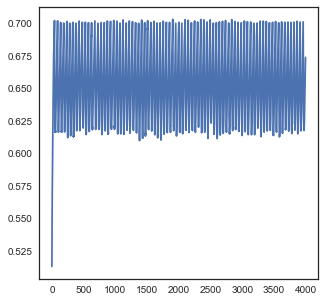

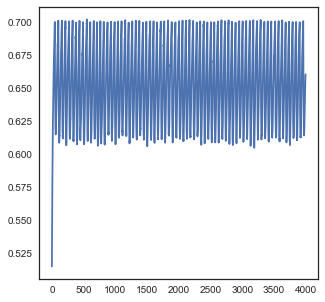

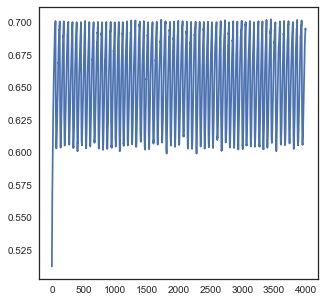

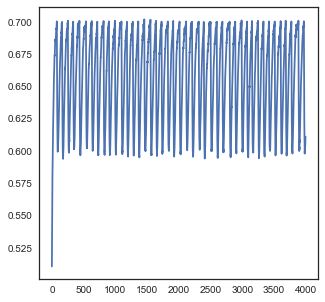

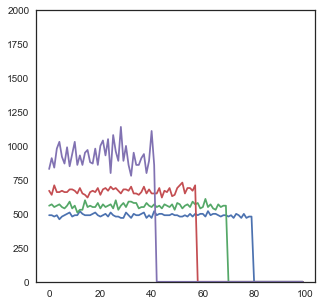

In [34]:
dur = 40000
nI = 4
Ilst = np.linspace(0.75,0.78, nI)
ipi = np.zeros((nI,100))
ulst = np.zeros((nI,int(dur/PARAMS_DICT['dt'])))
vlst = np.zeros((nI,int(dur/PARAMS_DICT['dt'])))
ylst = np.zeros((nI,int(dur/PARAMS_DICT['dt'])))
pressT = np.zeros((nI,100))
for i in range(nI):
    print(i)
    u_p, v_p, y_p, I_p, production_lst = simulate_production(ntrials=1, duration = dur, sigma=0.01, initI=Ilst[i])
    
    press_times = np.multiply(np.nonzero(production_lst),PARAMS_DICT['dt'])
    
    pressT[i,:np.size(press_times[0,:])] = press_times[0,:]
    ipi[i,:np.size(press_times[0,:])-1] = np.diff(press_times[0,:])
    print(len(u_p))
    ulst[i,:] = u_p
    vlst[i,:] = v_p
    ylst[i,:] = y_p
    plt.figure(figsize=(5, 5))
    plt.plot(y_p)

x = {}
x['ulst'] = ulst
x['vlst'] = vlst
x['ylst'] = ylst
x['Ilst'] = Ilst
x['ipi'] = ipi
x['pressT'] = pressT
scipy.io.savemat('productionData_many.mat',x)
plt.figure(figsize=(5,5))
for i in range(nI):
    plt.plot(ipi[i,:])
    plt.ylim(0,2000)

## MPM simulations (extended range of I)

0
4000
1
4000
2
4000
3
4000
4
4000
5
4000
6
4000
7
4000
8
4000
9
4000
10
4000
11
4000
12
4000
13
4000
14
4000
15
4000
16
4000
17
4000
18
4000
19
4000
20
4000
21
4000
22
4000
23
4000
24
4000
25
4000
26
4000
27
4000
28
4000
29
4000
30
4000
31
4000
32
4000
33
4000
34
4000
35
4000
36
4000
37
4000
38
4000
39
4000
40
4000
41
4000
42
4000
43
4000
44
4000
45
4000
46
4000
47
4000
48
4000
49
4000
50
4000
51
4000
52
4000
53
4000
54
4000
55
4000
56
4000
57
4000
58
4000
59
4000
60
4000
61
4000
62
4000
63
4000
64
4000
65
4000
66
4000
67
4000
68
4000
69
4000
70
4000
71
4000
72
4000
73
4000
74
4000
75
4000
76
4000
77
4000
78
4000
79
4000
80
4000
81
4000
82
4000
83
4000
84
4000
85
4000
86
4000
87
4000
88
4000
89
4000
90
4000
91
4000
92
4000
93
4000
94
4000
95
4000
96
4000
97
4000
98
4000
99
4000
100
4000
101
4000
102
4000
103
4000
104
4000
105
4000
106
4000
107
4000
108
4000
109
4000
110
4000
111
4000
112
4000
113
4000
114
4000
115
4000
116
4000
117
4000
118
4000
119
4000
120
4000
121
4000
122
4000
123

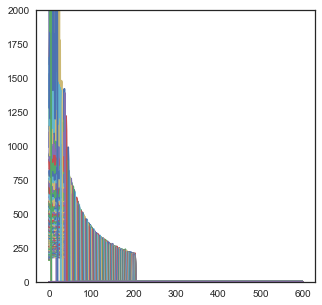

In [36]:
dur = 40000
nI = 40
Ilst = np.linspace(0.2,0.8, nI)
ipi = np.zeros((nI,600))
ulst = np.zeros((nI,int(dur/PARAMS_DICT['dt'])))
vlst = np.zeros((nI,int(dur/PARAMS_DICT['dt'])))
ylst = np.zeros((nI,int(dur/PARAMS_DICT['dt'])))
pressT = np.zeros((nI,600))
for i in range(nI):
    print(i)
    u_p, v_p, y_p, I_p, production_lst = simulate_production(ntrials=1, duration = dur, sigma=0.01, initI=Ilst[i])
    
    press_times = np.multiply(np.nonzero(production_lst),PARAMS_DICT['dt'])
    
    if np.size(press_times[0,:]) > 0:
        pressT[i,:np.size(press_times[0,:])] = press_times[0,:]
        ipi[i,:np.size(press_times[0,:])-1] = np.diff(press_times[0,:])
        
    print(len(u_p))
    ulst[i,:] = u_p
    vlst[i,:] = v_p
    ylst[i,:] = y_p
    #plt.figure(figsize=(5, 5))
    #plt.plot(y_p)

x = {}
x['ulst'] = ulst
x['vlst'] = vlst
x['ylst'] = ylst
x['Ilst'] = Ilst
x['ipi'] = ipi
x['pressT'] = pressT
scipy.io.savemat('productionData_I0_larger_range.mat',x)
plt.figure(figsize=(5,5))
for i in range(nI):
    plt.plot(ipi[i,:])
    plt.ylim(0,2000)

## MPM simulations (extended range of I; y_0 = 0.5)

0
4000
1
4000
2
4000
3
4000
4
4000
5
4000
6
4000
7
4000
8
4000
9
4000
10
4000
11
4000
12
4000
13
4000
14
4000
15
4000
16
4000
17
4000
18
4000
19
4000
20
4000
21
4000
22
4000
23
4000
24
4000
25
4000
26
4000
27
4000
28
4000
29
4000
30
4000
31
4000
32
4000
33
4000
34
4000
35
4000
36
4000
37
4000
38
4000
39
4000


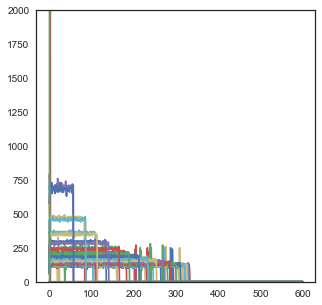

In [29]:
dur = 40000
nI = 40
Ilst = np.linspace(0.05,0.95, nI)
ipi = np.zeros((nI,600))
ulst = np.zeros((nI,int(dur/PARAMS_DICT['dt'])))
vlst = np.zeros((nI,int(dur/PARAMS_DICT['dt'])))
ylst = np.zeros((nI,int(dur/PARAMS_DICT['dt'])))
pressT = np.zeros((nI,600))
for i in range(nI):
    print(i)
    u_p, v_p, y_p, I_p, production_lst = simulate_production2(ntrials=1, duration = dur, sigma=0.01, initI=Ilst[i], y0=0.5)
    
    press_times = np.multiply(np.nonzero(production_lst),PARAMS_DICT['dt'])
    
    if np.size(press_times[0,:]) > 0:
        pressT[i,:np.size(press_times[0,:])] = press_times[0,:]
        ipi[i,:np.size(press_times[0,:])-1] = np.diff(press_times[0,:])
        
    print(len(u_p))
    ulst[i,:] = u_p
    vlst[i,:] = v_p
    ylst[i,:] = y_p
    #plt.figure(figsize=(5, 5))
    #plt.plot(y_p)

x = {}
x['ulst'] = ulst
x['vlst'] = vlst
x['ylst'] = ylst
x['Ilst'] = Ilst
x['ipi'] = ipi
x['pressT'] = pressT
scipy.io.savemat('productionData_I0_larger_range_y0_050.mat',x)
plt.figure(figsize=(5,5))
for i in range(nI):
    plt.plot(ipi[i,:])
    plt.ylim(0,2000)

## MPM simulations (extended range of I; y_0 = 0.55)

0
4000
1
4000
2
4000
3
4000
4
4000
5
4000
6
4000
7
4000
8
4000
9
4000
10
4000
11
4000
12
4000
13
4000
14
4000
15
4000
16
4000
17
4000
18
4000
19
4000
20
4000
21
4000
22
4000
23
4000
24
4000
25
4000
26
4000
27
4000
28
4000
29
4000
30
4000
31
4000
32
4000
33
4000
34
4000
35
4000
36
4000
37
4000
38
4000
39
4000


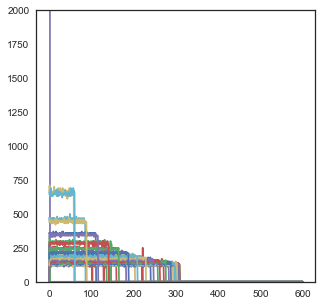

In [30]:
dur = 40000
nI = 40
Ilst = np.linspace(0.05,0.95, nI)
ipi = np.zeros((nI,600))
ulst = np.zeros((nI,int(dur/PARAMS_DICT['dt'])))
vlst = np.zeros((nI,int(dur/PARAMS_DICT['dt'])))
ylst = np.zeros((nI,int(dur/PARAMS_DICT['dt'])))
pressT = np.zeros((nI,600))
for i in range(nI):
    print(i)
    u_p, v_p, y_p, I_p, production_lst = simulate_production2(ntrials=1, duration = dur, sigma=0.01, initI=Ilst[i], y0=0.55)
    
    press_times = np.multiply(np.nonzero(production_lst),PARAMS_DICT['dt'])
    
    if np.size(press_times[0,:]) > 0:
        pressT[i,:np.size(press_times[0,:])] = press_times[0,:]
        ipi[i,:np.size(press_times[0,:])-1] = np.diff(press_times[0,:])
        
    print(len(u_p))
    ulst[i,:] = u_p
    vlst[i,:] = v_p
    ylst[i,:] = y_p
    #plt.figure(figsize=(5, 5))
    #plt.plot(y_p)

x = {}
x['ulst'] = ulst
x['vlst'] = vlst
x['ylst'] = ylst
x['Ilst'] = Ilst
x['ipi'] = ipi
x['pressT'] = pressT
scipy.io.savemat('productionData_I0_larger_range_y0_055.mat',x)
plt.figure(figsize=(5,5))
for i in range(nI):
    plt.plot(ipi[i,:])
    plt.ylim(0,2000)

## MPM simulations (extended range of I; y_0 = 0.45)

0
4000
1
4000
2
4000
3
4000
4
4000
5
4000
6
4000
7
4000
8
4000
9
4000
10
4000
11
4000
12
4000
13
4000
14
4000
15
4000
16
4000
17
4000
18
4000
19
4000
20
4000
21
4000
22
4000
23
4000
24
4000
25
4000
26
4000
27
4000
28
4000
29
4000
30
4000
31
4000
32
4000
33
4000
34
4000
35
4000
36
4000
37
4000
38
4000
39
4000


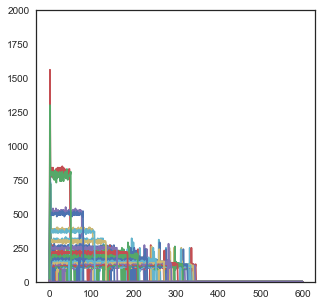

In [32]:
dur = 40000
nI = 40
Ilst = np.linspace(0.05,0.95, nI)
ipi = np.zeros((nI,600))
ulst = np.zeros((nI,int(dur/PARAMS_DICT['dt'])))
vlst = np.zeros((nI,int(dur/PARAMS_DICT['dt'])))
ylst = np.zeros((nI,int(dur/PARAMS_DICT['dt'])))
pressT = np.zeros((nI,600))
for i in range(nI):
    print(i)
    u_p, v_p, y_p, I_p, production_lst = simulate_production2(ntrials=1, duration = dur, sigma=0.01, initI=Ilst[i], y0=0.45)
    
    press_times = np.multiply(np.nonzero(production_lst),PARAMS_DICT['dt'])
    
    if np.size(press_times[0,:]) > 0:
        pressT[i,:np.size(press_times[0,:])] = press_times[0,:]
        ipi[i,:np.size(press_times[0,:])-1] = np.diff(press_times[0,:])
        
    print(len(u_p))
    ulst[i,:] = u_p
    vlst[i,:] = v_p
    ylst[i,:] = y_p
    #plt.figure(figsize=(5, 5))
    #plt.plot(y_p)

x = {}
x['ulst'] = ulst
x['vlst'] = vlst
x['ylst'] = ylst
x['Ilst'] = Ilst
x['ipi'] = ipi
x['pressT'] = pressT
scipy.io.savemat('productionData_I0_larger_range_y0_045.mat',x)
plt.figure(figsize=(5,5))
for i in range(nI):
    plt.plot(ipi[i,:])
    plt.ylim(0,2000)

## MPM simulations (vary $\sigma_n$)

0.00076
0.0010932219151
0.00157254494165
0.00226202709564
0.00325381262303
0.0046804464041
0.00673258760712
0.00968448989134
0.0139306534023
0.0200385468304
0.0288244454496
0.0414625203369
0.0596417577467
0.085791679768
0.123407032178
0.177514831651
0.255346189758
0.367302698131
0.528346525095
0.76


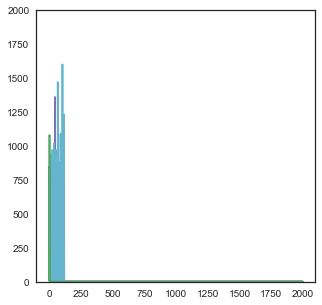

In [71]:
dur = 40000
nsig = 20
Itemp = 0.76
siglst = np.logspace(-3,0, nsig)*Itemp
ipi = np.zeros((nsig,2000))
ulst = np.zeros((nsig,int(dur/PARAMS_DICT['dt'])))
vlst = np.zeros((nsig,int(dur/PARAMS_DICT['dt'])))
ylst = np.zeros((nsig,int(dur/PARAMS_DICT['dt'])))
pressT = np.zeros((nI,2000))
for i in range(nsig):
    print(siglst[i])
    u_p, v_p, y_p, I_p, production_lst = simulate_production(ntrials=1, duration = dur, sigma=siglst[i], initI=Itemp)
    
    press_times = np.multiply(np.nonzero(production_lst),PARAMS_DICT['dt'])
    
    if np.size(press_times[0,:]) > 0:
        pressT[i,:np.size(press_times[0,:])] = press_times[0,:]
        ipi[i,:np.size(press_times[0,:])-1] = np.diff(press_times[0,:])
    ulst[i,:] = u_p
    vlst[i,:] = v_p
    ylst[i,:] = y_p
    #plt.figure(figsize=(5, 5))
    #plt.plot(y_p)

x = {}
x['ulst'] = ulst
x['vlst'] = vlst
x['ylst'] = ylst
x['siglst'] = siglst
x['ipi'] = ipi
x['pressT'] = pressT
x['I'] = Itemp
scipy.io.savemat('productionData_varySig.mat',x)
plt.figure(figsize=(5,5))
for i in range(nsig):
    plt.plot(ipi[i,:])
    plt.ylim(0,2000)